<h1>Sleep Spindle Visualisation & Modelling</h1>

In this notebook, we investigate EEG recordings from the <i>physionet.org</i> database, specifically their <i>The Sleep-EDF Database [Expanded]</i> database. The link to the page with the datasets available to download is shown below.

<b>The Sleep-EDF Database [Expanded]</b>
https://physionet.org/physiobank/database/sleep-edfx/

In essence, dataset is divided into two categories: Sleep Cassette Study and Data (SC) and Sleep Telemetry Study and Data (ST). In this project, we focused on data in the Sleep Cassette database

- <b>Sleep Cassette Study and Data (SC)</b>: In this study conducted between 1897 and 1991, 154 Caucasians aged between 25-101 without any sleep-related medication. Two PSGs of about 20 hours each were recorded during two subsequent day-night periods at the subjects homes. Subjects continued their normal activities but wore a modified Walkman-like cassette-tape recorder.

For each subject in the SC database, there is a <b>*PSG.edf</b> file for the whole night polysomnographic sleep recordings that include EEG (prefrontal and parietal electrode locations), EOG, submental chin EMG as well as oro-nasal respiration and rectal body temperature. 

The <b>*Hypnogram.edf</b> files contain annotations of the sleep patterns that correspond to the PSG files. These annotations need to be loaded to the raw PSG data in order for annotations to appear with the plotted PSG signals. The annotations mark the particular intervals of time that correspond to particular sleep stages. Recall that the sleep stages are:

- Wake (W)
- R
- Stage 1 (1)
- Stage 2 (2)
- Stage 3 (3)
- Stage 4 (4)
- Movement (M)
- Not scored (?)

In the following code cells, we use the <i><b>MNE</b></i> library to load the raw PSG data and perform pre-processing before we peform any form of DSP, data analysis or model-fitting.

In [1]:
# Importing some basic libraries including the MNE library.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne

In [2]:
# Assign the file name for the PSG and Hypnogram respectively.
f_psg = 'SC4002E0-PSG.edf' 
f_hyp = 'SC4002EC-Hypnogram.edf'

In [3]:
# Read the raw PSG file first before the hypnogram.
raw = mne.io.read_raw_edf(f_psg, preload=True)

Extracting EDF parameters from SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...


<ipython-input-3-cb461d4960a2>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw = mne.io.read_raw_edf(f_psg, preload=True)


In [4]:
# Output information regarding the raw edf file that was just loaded.
raw.info

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG submental, Temp rectal, STI 014
    chs : list | 7 items (EEG: 6, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 50.0 Hz
    meas_date : tuple | 1989-04-25 14:50:00 GMT
    nchan : int | 7
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 100.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
 

In [5]:
# Print out the channel names in the PSG recording.
raw.info['ch_names']

['EEG Fpz-Cz',
 'EEG Pz-Oz',
 'EOG horizontal',
 'Resp oro-nasal',
 'EMG submental',
 'Temp rectal',
 'STI 014']

From the above, we can see two EEG channels that we will most likely be focusing on. The rest are EOG, EMG and other measurements taken. The ```STI 014``` is the stimulus channel used to detect events in the recording.

In [6]:
# Find events in the PSG recording.
events = mne.find_events(raw, stim_channel='STI 014', consecutive=True, output='onset')

Trigger channel has a non-zero initial value of 977 (consider using initial_event=True to detect this event)
81512 events found
Event IDs: [  95  103  116  122  123  127  130  131  133  134  143  147  799  820
  824  828  831  832  833  834  837  838  843  844  848  850  854  855
  857  858  861  862  863  864  865  866  867  869  870  871  872  873
  874  875  876  877  878  880  881  882  883  884  885  886  887  888
  889  890  891  892  893  894  895  896  897  898  899  900  901  902
  903  904  905  906  907  908  909  910  911  912  913  914  915  916
  917  918  919  920  921  922  923  924  925  926  927  928  929  930
  931  932  933  934  935  936  937  938  939  940  941  942  943  944
  945  946  947  948  949  950  951  952  953  954  955  956  957  958
  959  960  961  962  963  964  965  966  967  968  969  970  971  972
  973  974  975  976  977  978  979  980  981  982  983  984  985  986
  987  988  989  990  991  992  993  994  995  996  997  998  999 1000
 1001 100

In [7]:
events.shape

(81512, 3)

In [8]:
events[:5]

array([[ 100,  977,  979],
       [ 200,  979,  997],
       [ 301,  997, 1015],
       [ 400, 1015, 1016],
       [ 500, 1016, 1044]])

The subsequent code below is a temporary function written by the developers at MNE that allow an external annotations file (in the form of an ```.edf``` file) to be loaded. The function returns the annotations that can be assigned to a variable. We would then proceed to load the annotations onto the raw PSG that was loaded initially.

In [9]:
import re
import pandas as pd
import mne


def read_edf_annotations(fname):
    """read_edf_annotations

    Parameters:
    -----------
    fname : str
        Path to file.

    Returns:
    --------
    annot : DataFrame
        The annotations
    """
    with open(fname, 'r', encoding='utf-8',
              errors='ignore') as annotions_file:
        tal_str = annotions_file.read()

    exp = '(?P<onset>[+\-]\d+(?:\.\d*)?)' + \
          '(?:\x15(?P<duration>\d+(?:\.\d*)?))?' + \
          '(\x14(?P<description>[^\x00]*))?' + '(?:\x14\x00)'

    annot = [m.groupdict() for m in re.finditer(exp, tal_str)]

    good_annot = pd.DataFrame(annot)
    good_annot = good_annot.query('description != ""').copy()
    good_annot.loc[:, 'duration'] = good_annot['duration'].astype(float)
    good_annot.loc[:, 'onset'] = good_annot['onset'].astype(float)
    return good_annot


def resample_30s(annot):
    annot = annot.set_index('onset')
    annot.index = pd.to_timedelta(annot.index, unit='s')
    annot = annot.resample('30s').ffill()
    annot = annot.reset_index()
    annot['duration'] = 30.
    return annot

annot = read_edf_annotations(f_hyp)
#annot = resample_30s(annot)

mne_annot = mne.Annotations(annot.onset, annot.duration, annot.description)

print(mne_annot)

<Annotations  |  152 segments : movement (1), sleep (151), orig_time : None>


In [10]:
print(type(mne_annot))

<class 'mne.annotations.Annotations'>


In [11]:
# Loading the annotations onto the raw PSG data
raw.set_annotations(mne_annot)

<ipython-input-11-f56d6c5eb2a7>:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne_annot)


<RawEDF  |  SC4002E0-PSG.edf, n_channels x n_times : 7 x 8490000 (84900.0 sec), ~453.4 MB, data loaded>

In [12]:
# We now obtain the events and event_id from the raw data after the annotations being loaded.
events2, event_id = mne.events_from_annotations(raw) 

Used Annotations descriptions: ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Movement time', 'Sleep stage R', 'Sleep stage ?']


We would proceed to plot the raw data along with the annotations in the form of ```events```. In this case, I have commented it out unless the plot is required.

In [13]:
order = np.arange(raw.info['nchan'])

#%matplotlib qt
#raw.plot(block=True, order=order, events=events)
#plt.show()

We now want to split the entire recording into segments called <i>epochs</i>. These epochs are chunks of the EEG defined by some stage and end time that we choose (in this case, from t = 0 to t = 30) as well as the events obtained earlier. 

In [14]:
# Using the events
epochs = mne.Epochs(raw, events2, event_id, tmin=0., tmax=30.,baseline=None)

152 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [15]:
epochs

<Epochs  |   152 events (good & bad), 0 - 30 sec, baseline off, ~18 kB, data not loaded,
 'Movement time': 1
 'Sleep stage 1': 32
 'Sleep stage 2': 37
 'Sleep stage 3': 30
 'Sleep stage 4': 16
 'Sleep stage ?': 1
 'Sleep stage R': 12
 'Sleep stage W': 23>

We would proceed to plot the same recording but now with the epochs clearly identified in the plot. Again, I have commented this out unless the plot is required. 

In [16]:
#epochs.plot()
#plt.show()

In [17]:
index, scaling_time, scalings = ['epoch', 'time'], 1e3, dict(grad=1e13)

df = epochs.to_data_frame(picks=None, scalings=scalings,
                          scaling_time=scaling_time, index=index)

Loading data for 152 events and 3001 original time points ...
1 bad epochs dropped
Converting time column to int64...


In [18]:
df

signal           condition  EEG Fpz-Cz  EEG Pz-Oz  EOG horizontal  \
epoch time                                                          
0     0      Sleep stage W  -48.939194   0.067399       34.984127   
      10     Sleep stage W   -8.715751  -3.270330       39.324786   
      20     Sleep stage W  -32.544322  -1.208791       52.346764   
      30     Sleep stage W  -24.499634  -1.208791       52.829060   
      40     Sleep stage W  -35.395604   2.521612       48.488400   
      50     Sleep stage W  -27.860073   2.521612       31.125763   
      60     Sleep stage W  -27.147253   2.128938       26.785104   
      70     Sleep stage W  -16.047619   2.128938       21.479853   
      80     Sleep stage W  -32.136996   1.049084       23.409035   
      90     Sleep stage W  -30.100366  -0.816117       11.351648   
      100    Sleep stage W  -20.833700  -1.601465       46.559219   
      110    Sleep stage W  -20.426374  -7.295238       38.360195   
      120    Sleep stage W  -16.964103 -11.221978       16.656899   
      130    Sleep stage W  -13.603663  -8.375092       33.054945   
      140    Sleep stage W  -12.585348  -3.859341       28.231990   
      150    Sleep stage W   -6.984615  -6.117216       31.125763   
      160    Sleep stage W    3.096703  -4.055678       31.125763   
      170    Sleep stage W    6.966300  -2.975824       24.373626   
      180    Sleep stage W    0.041758  -0.521612        5.081807   
      190    Sleep stage W    3.300366  -1.797802       33.537241   
      200    Sleep stage W    2.791209  -3.270330       -0.705739   
      210    Sleep stage W  -10.854212  -2.681319        2.670330   
      220    Sleep stage W  -10.854212  -1.208791       26.785104   
      230    Sleep stage W   -7.493773  -1.012454        1.223443   
      240    Sleep stage W  -12.279853  -6.313553        6.528694   
      250    Sleep stage W  -15.843956  -6.019048       -6.010989   
      260    Sleep stage W   -2.605861  -6.411722       -2.152625   
      270    Sleep stage W  -17.065934  -0.619780      -17.103785   
      280    Sleep stage W   -3.624176   3.012454        4.117216   
      290    Sleep stage W   -9.530403   4.288645        2.188034   
...                    ...         ...        ...             ...   
150   29710  Sleep stage W   -2.809524  -7.491575       12.798535   
      29720  Sleep stage W    8.391941 -12.400000       28.714286   
      29730  Sleep stage W   13.890842 -11.909158       21.479853   
      29740  Sleep stage W   18.982418 -12.301832       20.515263   
      29750  Sleep stage W   17.353114  -6.215385       22.926740   
      29760  Sleep stage W    2.994872  -4.350183       39.807082   
      29770  Sleep stage W    3.809524  -3.859341       37.395604   
      29780  Sleep stage W    1.467399  -5.528205       44.630037   
      29790  Sleep stage W   13.076190 -13.970696       29.196581   
      29800  Sleep stage W   15.927473 -17.799267       30.643468   
      29810  Sleep stage W   17.047619 -12.596337       48.970696   
      29820  Sleep stage W   19.084249 -12.400000       49.452991   
      29830  Sleep stage W   18.065934 -11.221978       45.594628   
      29840  Sleep stage W   16.232967  -7.884249       29.196581   
      29850  Sleep stage W   16.334799  -3.172161       39.807082   
      29860  Sleep stage W   15.316484   1.736264       18.103785   
      29870  Sleep stage W   14.603663   8.117216       21.479853   
      29880  Sleep stage W    7.577289  11.945788       21.962149   
      29890  Sleep stage W    2.893040  10.080586       20.032967   
      29900  Sleep stage W    6.864469   5.073993       25.338217   
      29910  Sleep stage W   14.400000   2.717949       28.231990   
      29920  Sleep stage W   -5.864469  -5.331868       17.139194   
      29930  Sleep stage W   -4.947985  -9.160440       30.643468   
      29940  Sleep stage W   10.123077  -2.386813       12.798535   
      29950  Sleep stage W   12.567033  -9.062271       26.302808  

In [19]:
# Obtain ONLY parts of the dataframe where the sleep stage is defined as Stage 2:
stage2_df = df[df['condition'] == 'Sleep stage 2']

In [20]:
stage2_df

signal           condition  EEG Fpz-Cz  EEG Pz-Oz  EOG horizontal  \
epoch time                                                          
2     0      Sleep stage 2    4.522344  -7.589744        7.975580   
      10     Sleep stage 2    8.391941 -10.731136        2.670330   
      20     Sleep stage 2    4.522344  -9.651282       14.245421   
      30     Sleep stage 2   -2.198535  -9.356777        6.528694   
      40     Sleep stage 2    3.707692  -7.884249       13.763126   
      50     Sleep stage 2    7.780952  -8.571429       10.387057   
      60     Sleep stage 2    9.308425  -9.651282       -0.705739   
      70     Sleep stage 2   -1.485714  -7.884249        7.493284   
      80     Sleep stage 2    2.383883  -6.019048        4.117216   
      90     Sleep stage 2   -3.115018  -5.037363        2.188034   
      100    Sleep stage 2   -6.271795  -4.644689        1.705739   
      110    Sleep stage 2   -2.707692  -4.448352        5.081807   
      120    Sleep stage 2   -4.438828   0.852747        7.010989   
      130    Sleep stage 2    1.263736  -0.914286        8.940171   
      140    Sleep stage 2   -0.874725   0.460073        9.904762   
      150    Sleep stage 2   -0.569231  -3.466667        5.564103   
      160    Sleep stage 2   -1.282051  -5.822711        7.493284   
      170    Sleep stage 2   -9.530403  -2.190476        4.117216   
      180    Sleep stage 2   -6.068132  -0.423443        6.528694   
      190    Sleep stage 2  -11.465201  -0.914286        3.152625   
      200    Sleep stage 2   -0.060073  -1.994139        6.046398   
      210    Sleep stage 2   -8.715751  -7.098901        5.564103   
      220    Sleep stage 2   -4.744322  -1.797802        4.117216   
      230    Sleep stage 2  -13.298168  -2.484982       -2.634921   
      240    Sleep stage 2   -7.697436  -2.092308       -4.564103   
      250    Sleep stage 2  -12.483516  -4.252015       -1.188034   
      260    Sleep stage 2  -10.141392  -6.608059        2.188034   
      270    Sleep stage 2   -1.180220 -10.142125       -4.081807   
      280    Sleep stage 2   -4.133333  -6.411722       -6.493284   
      290    Sleep stage 2    4.827839  -8.865934       -3.117216   
...                    ...         ...        ...             ...   
149   29710  Sleep stage 2    7.271795  12.632967       11.833944   
      29720  Sleep stage 2   15.520147   9.589744        7.010989   
      29730  Sleep stage 2   17.149451   5.859341        6.528694   
      29740  Sleep stage 2   16.742125   5.663004       10.387057   
      29750  Sleep stage 2   15.723810   5.466667       10.387057   
      29760  Sleep stage 2   17.862271   5.466667       13.280830   
      29770  Sleep stage 2   16.640293  10.375092       15.210012   
      29780  Sleep stage 2    9.817582  12.142125       16.656899   
      29790  Sleep stage 2    1.874725  15.970696       17.139194   
      29800  Sleep stage 2    3.605861  21.271795       12.798535   
      29810  Sleep stage 2    6.966300  25.885714       16.174603   
      29820  Sleep stage 2   -0.874725  27.358242        8.940171   
      29830  Sleep stage 2   -1.485714  27.849084       17.621490   
      29840  Sleep stage 2  -10.446886  33.052015        9.904762   
      29850  Sleep stage 2   -3.522344  35.506227       11.351648   
      29860  Sleep stage 2   -8.817582  34.622711        3.152625   
      29870  Sleep stage 2  -10.446886  29.616117        8.457875   
      29880  Sleep stage 2   -5.253480  27.947253        0.258852   
      29890  Sleep stage 2   -6.984615  21.958974        5.564103   
      29900  Sleep stage 2  -12.687179  17.148718        6.046398   
      29910  Sleep stage 2  -13.094505  14.105495      -11.798535   
      29920  Sleep stage 2  -12.789011  12.338462        7.010989   
      29930  Sleep stage 2  -17.880586  14.498168       -0.705739   
      29940  Sleep stage 2  -17.982418  19.112088        3.634921   
      29950  Sleep stage 2  -21.342857  23.824176        0.258852  

In [21]:
print(stage2_df.index.names, stage2_df.index.levels)

['epoch', 'time'] [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, ...]]


In [22]:
print(stage2_df.columns)

Index(['condition', 'EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal',
       'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'STI 014'],
      dtype='object', name='signal')


In [23]:
# Most likely will drop all columns except for those related to EEG and STI 014 stimulus channel:
eeg_channels = ['EEG Fpz-Cz', 'EEG Pz-Oz']

stage2_eeg_df = stage2_df[eeg_channels]

In [24]:
stage2_eeg_df

signal       EEG Fpz-Cz  EEG Pz-Oz
epoch time                        
2     0        4.522344  -7.589744
      10       8.391941 -10.731136
      20       4.522344  -9.651282
      30      -2.198535  -9.356777
      40       3.707692  -7.884249
      50       7.780952  -8.571429
      60       9.308425  -9.651282
      70      -1.485714  -7.884249
      80       2.383883  -6.019048
      90      -3.115018  -5.037363
      100     -6.271795  -4.644689
      110     -2.707692  -4.448352
      120     -4.438828   0.852747
      130      1.263736  -0.914286
      140     -0.874725   0.460073
      150     -0.569231  -3.466667
      160     -1.282051  -5.822711
      170     -9.530403  -2.190476
      180     -6.068132  -0.423443
      190    -11.465201  -0.914286
      200     -0.060073  -1.994139
      210     -8.715751  -7.098901
      220     -4.744322  -1.797802
      230    -13.298168  -2.484982
      240     -7.697436  -2.092308
      250    -12.483516  -4.252015
      260    -10.141392  -6.608059
      270     -1.180220 -10.142125
      280     -4.133333  -6.411722
      290      4.827839  -8.865934
...                 ...        ...
149   29710    7.271795  12.632967
      29720   15.520147   9.589744
      29730   17.149451   5.859341
      29740   16.742125   5.663004
      29750   15.723810   5.466667
      29760   17.862271   5.466667
      29770   16.640293  10.375092
      29780    9.817582  12.142125
      29790    1.874725  15.970696
      29800    3.605861  21.271795
      29810    6.966300  25.885714
      29820   -0.874725  27.358242
      29830   -1.485714  27.849084
      29840  -10.446886  33.052015
      29850   -3.522344  35.506227
      29860   -8.817582  34.622711
      29870  -10.446886  29.616117
      29880   -5.253480  27.947253
      29890   -6.984615  21.958974
      29900  -12.687179  17.148718
      29910  -13.094505  14.105495
      29920  -12.789011  12.338462
      29930  -17.880586  14.498168
      29940  -17.982418  19.112088
      29950  -21.342857  23.824176
      29960  -10.446886  27.947253
      29970   -8.919414  31.972161
      29980   -0.569231  32.266667
      29990   -3.522344  32.168498
      30000   -1.994872  31.873993

[111037 rows x 2 columns]

In [25]:
stage2_df = stage2_df.reset_index()

In [26]:
stage2_df

signal,epoch,time,condition,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,Resp oro-nasal,EMG submental,Temp rectal,STI 014
0,2,0,Sleep stage 2,4.522344,-7.589744,7.975580,50000000.0,2.420,3.696425e+07,1024.0
1,2,10,Sleep stage 2,8.391941,-10.731136,2.670330,54000000.0,2.412,3.696519e+07,1024.0
2,2,20,Sleep stage 2,4.522344,-9.651282,14.245421,58000000.0,2.406,3.696519e+07,1024.0
3,2,30,Sleep stage 2,-2.198535,-9.356777,6.528694,62000000.0,2.398,3.696613e+07,1024.0
4,2,40,Sleep stage 2,3.707692,-7.884249,13.763126,66000000.0,2.392,3.696613e+07,1024.0
5,2,50,Sleep stage 2,7.780952,-8.571429,10.387057,70000000.0,2.386,3.696613e+07,1024.0
6,2,60,Sleep stage 2,9.308425,-9.651282,-0.705739,74000000.0,2.380,3.696707e+07,1024.0
7,2,70,Sleep stage 2,-1.485714,-7.884249,7.493284,79000000.0,2.374,3.696707e+07,1024.0
8,2,80,Sleep stage 2,2.383883,-6.019048,4.117216,83000000.0,2.368,3.696802e+07,1024.0
9,2,90,Sleep stage 2,-3.115018,-5.037363,2.188034,88000000.0,2.364,3.696802e+07,1024.0


In [27]:
stage2_df['epoch'].unique()

array([  2,  13,  15,  17,  19,  21,  23,  41,  43,  47,  51,  53,  55,
        62,  64,  68,  73,  75,  79,  82,  86,  93,  95,  97, 101, 103,
       105, 116, 120, 122, 125, 131, 138, 141, 144, 147, 149])

In [28]:
# Since dataframe consists ONLY of stage 2 data, we are free to segment the data by the epochs column 
# and plot using the usual libraries

x_bool = (stage2_df['epoch'] == 101)
x_temp = stage2_df[x_bool]
x = x_temp['time'] / 1e3

y_bool = (stage2_df['epoch'] == 101)
y_temp = stage2_df[y_bool]
y = y_temp['EEG Fpz-Cz']

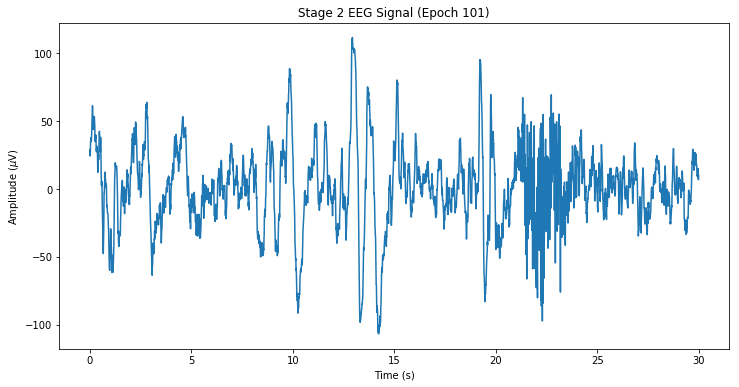

In [29]:
%matplotlib inline
fig = plt.figure(figsize=(12,6))
plt.plot(x,y)
plt.title('Stage 2 EEG Signal (Epoch 101)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude ($\mu$V)')
plt.show()

There is a spindle occurence in the interval $t \in [20,25]$. We can extract that portion of the epoch and assign it to its own numpy array for further investigation, perhaps alongside the QPS waveform. Might make it easier if we convert to a dataframe first and reset indices:

In [30]:
x = x.reset_index()
y = y.reset_index()

In [31]:
x_temp = list(x['time'])
x_spindle = x_temp[2000:2500]
x_new = []

for i in x_spindle:
    tmp = i - 20
    x_new.append(tmp)

y_temp = list(y['EEG Fpz-Cz'])
y_spindle = y_temp[2000:2500]

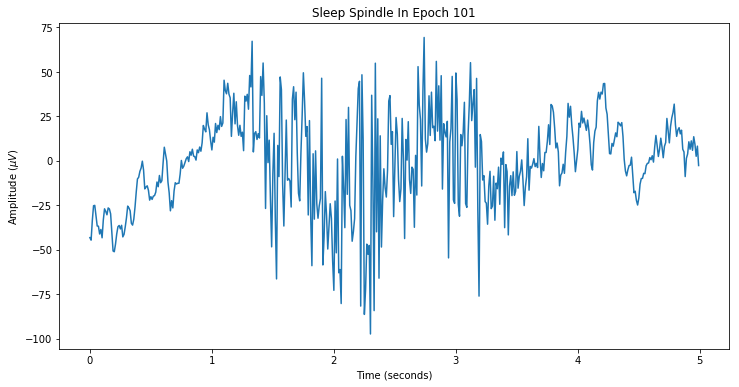

In [32]:
fig = plt.figure(figsize=(12,6))
plt.plot(x_new, y_spindle)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude ($\mu V$)')
plt.title('Sleep Spindle In Epoch 101')
plt.show()

In [33]:
import scipy.signal as signal
import scipy.fftpack as fftp

# Obtain frequency vector:
n = len(x_spindle)
fs = 100
Ts = 1/fs
xf = np.fft.fftfreq(n, d=1/fs)

# Obtain transformed
yf = fftp.fft(y_spindle)
y_mag = (abs(yf) / n) * 2

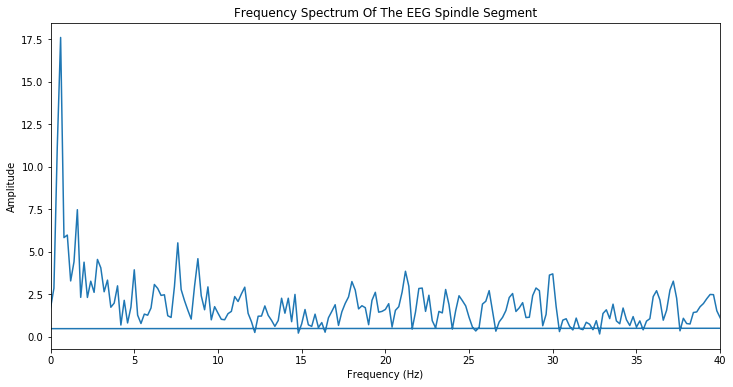

In [34]:
fig = plt.figure(figsize=(12,6))
plt.plot(xf, y_mag)
plt.xlim([0,40])
plt.title('Frequency Spectrum Of The EEG Spindle Segment')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

We are in a good position to begin performing some basic filtering on the signal. Specifically, we want to <i>denoise</i> the extracted spindle section and isolate the frequency components associated with the spindle. From the above frequency spectra, we notice a few things:

- The main frequency (and hence, power) contribution of the signal comes from frequency components with $f \leq 5 Hz$ as is evident from the maxima with amplitude of 17.5
- However, we have a local maxima located in $f \in [5,10]$. Perhaps the maxima corresponds to the spindle component of the signal. This is, of course, consistent with the definition of a sleep spindle. That is, a spindle generally lasts for 0.5-2 seconds with a frequency anywhere between 7-16 Hz. 

A good candidate filter would be to use a bandpass filter in the AASM defined frequency range and see if we can produce a filtered signal where the spindle is relatively more obvious to observe

In [35]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return b, a

In [36]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

In [37]:
# Time to use the defined functions to perform a bandpass filter on the spindle signal:

# Set up the parameters first:
fs = 100   # (Per raw.info)
low = 10   # (Lower bound of spindle frequency)
high = 12  # (Upper bound of spindle frequency)
order = 3  # (Order of the bandpass filter)

In [38]:
filt_out = butter_bandpass_filter(y_spindle, low, high, fs, order)

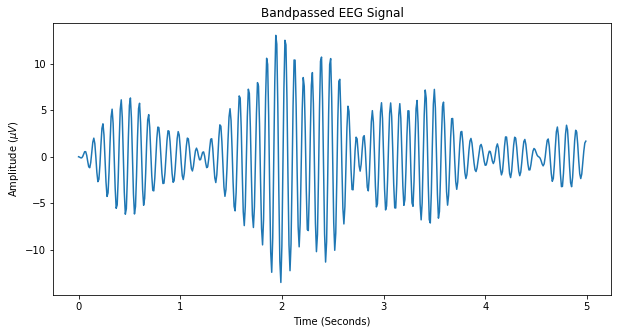

In [39]:
fig = plt.figure(figsize=(10,5))
plt.plot(x_new, filt_out)
plt.title('Bandpassed EEG Signal')
plt.xlabel('Time (Seconds)')
plt.ylabel('Amplitude ($\mu V$)')
plt.show()

The segment of the filtered signal in $t \in [1,3]$ seems to have a shape similar to that of an ordinary Gaussian pulse, a Gabor-Morlet Wavelet as well as the QPS model. Next step will be to extract this segment and produce the envelope for that segment using the Hilbert Transform and assess how consistent the signal segment is with the envelope of the models.

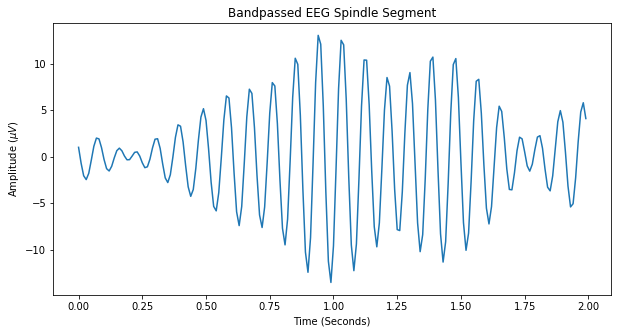

In [40]:
x_spindle_temp = x_new[100:300]
x_spindle_segment = []

for i in x_spindle_temp:
    tmp = i - 1
    x_spindle_segment.append(tmp)

y_spindle_segment = filt_out[100:300]

fig = plt.figure(figsize=(10,5))
plt.plot(x_spindle_segment, y_spindle_segment)
plt.title('Bandpassed EEG Spindle Segment')
plt.xlabel('Time (Seconds)')
plt.ylabel('Amplitude ($\mu V$)')
plt.show()

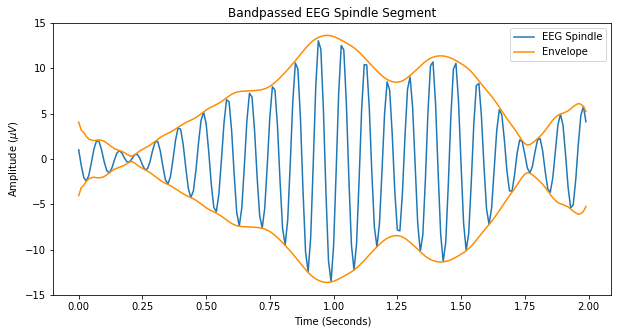

In [41]:
fig = plt.figure(figsize=(10,5))

env_tmp = signal.hilbert(y_spindle_segment)
spindle_pos = abs(env_tmp)
spindle_neg = -abs(env_tmp)
plt.plot(x_spindle_segment, y_spindle_segment, label='EEG Spindle')
plt.plot(x_spindle_segment, spindle_pos, color='darkorange', label='Envelope')
plt.plot(x_spindle_segment, spindle_neg, color='darkorange')

plt.title('Bandpassed EEG Spindle Segment')
plt.xlabel('Time (Seconds)')
plt.ylabel('Amplitude ($\mu V$)')
plt.legend()
plt.show()

We now align the QPS model onto the above spindle to see how well they align with the spindle. We first need to create a new time-vector for the x-axis to ensure the wavelet models are centered at $t = 0$ and have a duration of, in this case, approximately 2 seconds. 

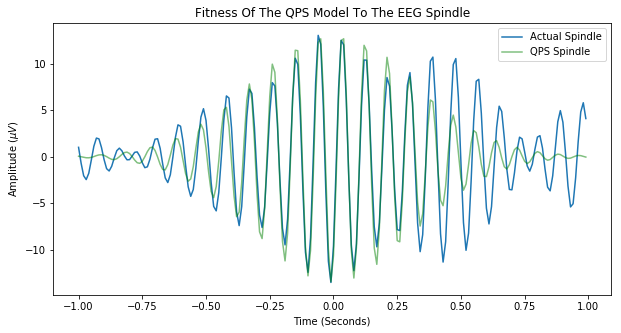

In [42]:
# Create a new x-axis from the original time-vector:
t = []
for i in x_spindle_segment:
    tmp = i - 1
    t.append(tmp)

# Format the figure environment for the plotted signals and model
fig = plt.figure(figsize=(10,5))
    
# Plot the original extracted spindle using the new time-vector for the x-axis
plt.plot(t, y_spindle_segment, label='Actual Spindle')
#plt.plot(t, spindle_pos, color='darkorange')
#plt.plot(t, spindle_neg, color='darkorange')

# Time to create the spindle. We start with the QPS Model.
# QPS Model
N = 200
fs = 100
T = 1/fs

t = np.linspace(-1,1, N, endpoint=False)

# Carrier frequency:
f = 11 # Sleep spindles 11-16Hz

# Parameters for the quadratic components
a, b, c = 2.6, 0, -5
d, e, f = 3.8, 70, 4.44

s_qps = np.exp(a + b*t + c*t**2) * np.cos(d + e*t + f*t**2)

analytic_sig = signal.hilbert(s_qps)
pos_env = np.abs(analytic_sig)
neg_env = - np.abs(analytic_sig)
plt.plot(t,s_qps,color='green', alpha=0.5, label='QPS Spindle')
#plt.plot(t, pos_env, color='green', alpha=0.5)
#plt.plot(t, neg_env, color='green', alpha=0.5)

plt.title('Fitness Of The QPS Model To The EEG Spindle')
plt.xlabel('Time (Seconds)')
plt.ylabel('Amplitude ($\mu V$)')

plt.legend()

plt.show()

We see that the after manual modifications to $a,b,c,d,e$ and $f \in \mathbb{R}$, we have managed to align the QPS model to majority of the bandpassed EEG spindle. However, we can see that the spindle itself does not taper off along with the QPS spindle from approximate 0.25 seconds to 0.75 seconds. It is clear that there is a residual formed between the filtered spindle and the QPS model. It might be useful to compute the residual and plot it along with the filtered spindle and the model.

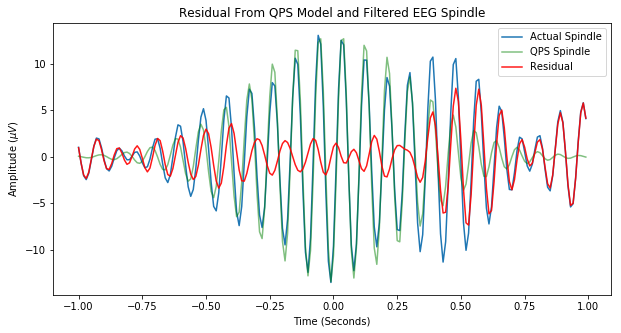

In [43]:
residual = []
residual = y_spindle_segment - s_qps

# Plotting everything together in one figure once more:
fig = plt.figure(figsize=(10,5))
plt.plot(t, y_spindle_segment, label='Actual Spindle')
plt.plot(t, s_qps,color='green', alpha=0.5, label='QPS Spindle')
plt.plot(t, residual, color='red', alpha=0.9, label='Residual')

plt.title('Residual From QPS Model and Filtered EEG Spindle')
plt.xlabel('Time (Seconds)')
plt.ylabel('Amplitude ($\mu V$)')

plt.legend()
plt.show()

The residual is at its smallest around 0.0 to 0.1 seconds where the model and the filtered signal are its best (as possible) alignment. The residual is much larger where the spindle is <i>meant</i> to taper off (i.e from 0.3 seconds onwards). While this is pretty decent, a goal would be to try and <b>minimise the residual</b> as much as possible.

That is, given an epoch (and hence a segment) containing a spindle, we have some way of <b>computing optimum values of $a,b,c,d,e,f \in \mathbb{R}$ that best fit the QPS model with the spindle segment.</b> However, because the model and the raw EEG data itself are not linear by nature, fitting the QPS model to the raw spindle data is now a <b>Non-Linear Least Squares (NLLS)</b> optimsation problem to be solved. 

<h2>Non-Linear Least Squares</h2>

Suppose we have a model that we would like to fit into our data. In the context of this project, this would be the QPS model. However, to generalise, suppose we have a <b>non-linear</b> model given by:

\begin{equation}
    \hat{y} = f(\mathbf{t}; \mathbf{a})
\end{equation}

Where $\mathbf{t} = (t_1, t_2...t_m)^T$ (which would be our time vector) and $\mathbf{a} = (a_1, a_2...a_n)^T$ would be a vector corresponding to the parameters of the model. Suppose the actual data is $y$. Then, the NLLS problem is the following:

\begin{equation}
    \min_{a_k \in \mathbf{a}} S = \sum_{i=1}^{N} \left(y^{(i)} - \hat{y}^{(i)} \right)^2
\end{equation}

That is, we wish to minimise the sum of squares of the residual and obtain the associated parameters with the minimised cost function. This is very similar when performing linear regression. However, now we have non-linear terms which means solving simulataneous derivatives during the optimization will be non-trivial. Furthermore, the fact that there are many parameters to optimize will prove the process of optimisation to also be non-trival.

Some of the typical methods used to optimise such non-linear cost functions include the <b>Gauss-Newton Method</b> as well as the <b>Levenberg-Marquadt</b> technique which both (like all NLLS algorithms) converge to the local or global minima for the cost function. Such methods are dependent on <b>how close the initial conditions are to the optimum values</b>.

In the case of the QPS model and the spindle data, we aim to first plot the QPS spindle and the actual spindle on one plot and <i>roughly</i> find the optimal parameters for the QPS spindle such that it aligns with the actual spindle. These parameters are then fed into the NLLS algorithm of choice along with the raw data and model to optimize the parameters. The closeness of the parameter assignments to the resulting optimum is to ensure that the algorithm will end up converging to the minima instead of diverging since the algorithm will behave much like the <b>Stochastic Gradient Descent</b> algorithm when very close to the minima of the cost function.

In the following code cells, we use the ```lmfit``` library, a dedicated Python library for performing NLLS optimisation problems with simple implementation.

In [44]:
from lmfit import Parameters, minimize

def residual(params, t, data):
    a, b, c = params['a'], params['b'], params['c']
    d, e, f = params['d'], params['e'], params['f']

    model = np.exp(a + b*t + c*t**2) * np.cos(d + e*t + f*t**2)
    chi = (data - model)
    
    return chi

# Set up an empty set of parameters:
params = Parameters()
params.add('a', value=2.2)
params.add('b', value=0)
params.add('c', value=-4.5)
params.add('d', value=3.4)
params.add('e', value=67)
params.add('f', value=4.30)
    
out = minimize(residual, params, args=(t, y_spindle_segment))

In [45]:
out

Suppose we have a try at using these values and see how well they match up with the actual spindle via a plot.

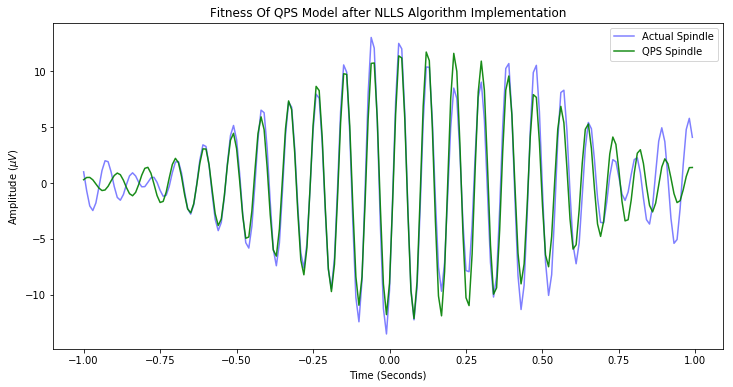

In [46]:
a, b, c = 2.47214878, 0.52836820, -2.67285936
d, e, f = 3.85417601, 70.0951595, 2.50223712

s_qps_nlls = np.exp(a + b*t + c*t**2) * np.cos(d + e*t + f*t**2)

analytic_sig = signal.hilbert(s_qps)
pos_env = np.abs(analytic_sig)
neg_env = - np.abs(analytic_sig)

fig = plt.figure(figsize=(12,6))
plt.plot(t, y_spindle_segment, alpha=0.5, color='blue', label='Actual Spindle')
plt.plot(t, s_qps_nlls, color='green', alpha=0.9, label='QPS Spindle')
plt.legend()

plt.title('Fitness Of QPS Model after NLLS Algorithm Implementation')
plt.xlabel('Time (Seconds)')
plt.ylabel('Amplitude ($\mu V$)')

plt.show()

The NLLS algorithm worked pretty well to optimise the parameters! Qualitatively, the plot shows a nicer alignment between the raw EEG spindle and the QPS model. The output from the ```minimise``` function shows that the optimised QPS model has a reduced chi-squared, $\chi^2 \approx 2.85 > 1$. What this means is while the model fits well, it does not fit it <i>completely</i> which should be clear from the above plot.

<h2>Analysing Another PSG From Another Subject</h2>

In this section, we aim to perform the same procedure for another PSG recording from another patient. We have the added benefit that necessary custom functions for loading annotations and basic filtering have already been constructed. The data loading, pre-processing and analysis begins from the following code cell.

In [47]:
# Assign the file names of the PSG and the annotations to variables
f_psg_2 = 'SC4001E0-PSG.edf'
f_hyp_2 = 'SC4001EC-Hypnogram.edf' 

In [48]:
# We first load the raw PSG data into a variable, 'raw_2' where using the MNE library
raw_2 = mne.io.read_raw_edf(f_psg_2, verbose=True, preload=True)

Extracting EDF parameters from SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<ipython-input-48-d0a5d88750a9>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_2 = mne.io.read_raw_edf(f_psg_2, verbose=True, preload=True)


In [49]:
# Checking if the raw file has been successfully loaded or not.
raw_2

<RawEDF  |  SC4001E0-PSG.edf, n_channels x n_times : 7 x 7950000 (79500.0 sec), ~424.6 MB, data loaded>

In [50]:
# Proceed to print the information in the RawEDF file:
print(raw_2.info)

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG submental, Temp rectal, STI 014
    chs : list | 7 items (EEG: 6, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 50.0 Hz
    meas_date : tuple | 1989-04-24 16:13:00 GMT
    nchan : int | 7
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 100.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
 

So that its easier in the latter steps, we note some of the important details from the information print out above:

- <b>Channel Names: </b> EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG submental, Temp rectal, STI 014
- <b>Sampling Frequency: </b> 100 Hz
- <b>Stimulus Channel Present: </b> Yes

In [51]:
# Check and confirm that there are no annotations in the current PSG loaded raw data:
raw_2.annotations

<Annotations  |  0 segments , orig_time : None>

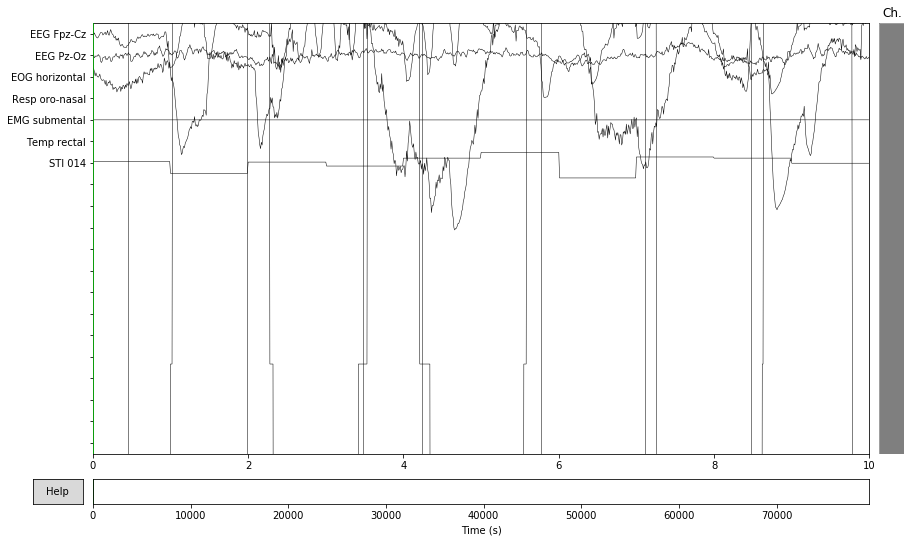

In [52]:
raw_2.plot(block=True)
plt.show()

As expected, there are no annotations in the PSG .edf alone. This will need to be added with the external .edf file containing the corresponding hypnogram for the raw sleep recording. Again, the hypnogram contains annotations that mark which sections of sleep corresponding to the W, 1, 2, 3, 4, ? and M stages. We load the annotations in the following code cell.

In [53]:
# Loading the annotations with the custom function 'read_edf_annotations()'
annot_2 = read_edf_annotations(f_hyp_2)

# Load 'annot_2' into the raw_2 data as annotations:
mne_annot = mne.Annotations(annot.onset, annot.duration, annot.description)
raw_2.set_annotations(mne_annot)

<ipython-input-53-1bc203bba1e4>:6: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_2.set_annotations(mne_annot)
<ipython-input-53-1bc203bba1e4>:6: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_2.set_annotations(mne_annot)


<RawEDF  |  SC4001E0-PSG.edf, n_channels x n_times : 7 x 7950000 (79500.0 sec), ~424.6 MB, data loaded>

In [54]:
raw_2.annotations

<Annotations  |  151 segments : movement (1), sleep (150), orig_time : 1989-04-24 16:13:00>

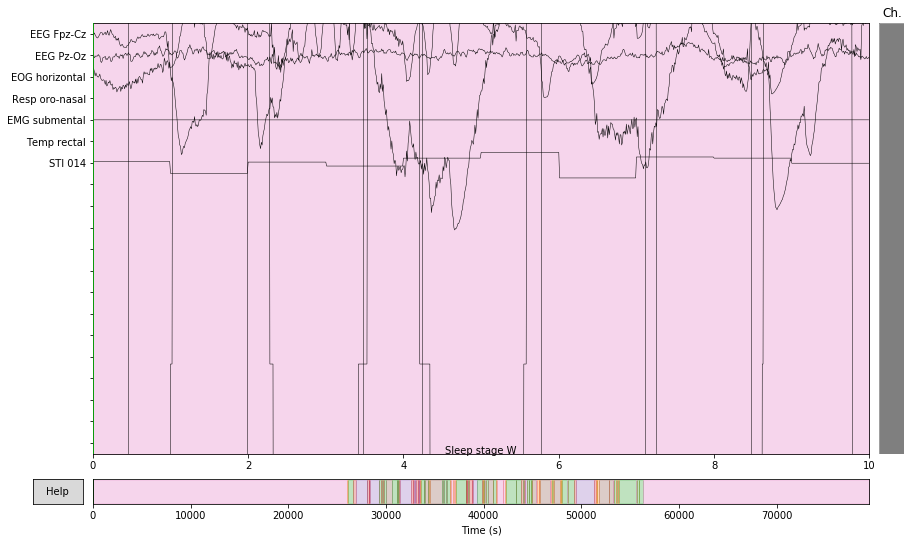

In [55]:
raw_2.plot()
plt.show()

The annotations are clearly shown on the graph! At this point, we are ready to extract the events, event IDs as well and, of course, the epochs from the raw sleep recording. We perform this in the following code cell.

In [56]:
# Obtain the events and event_ids
event_2, event_id_2 = mne.events_from_annotations(raw_2)

Used Annotations descriptions: ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Movement time', 'Sleep stage R']


In [57]:
epochs_2 = mne.Epochs(raw_2, event_2, event_id_2, baseline=None)

151 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


Loading data for 151 events and 71 original time points ...
1 bad epochs dropped
Loading data for 20 events and 71 original time points ...


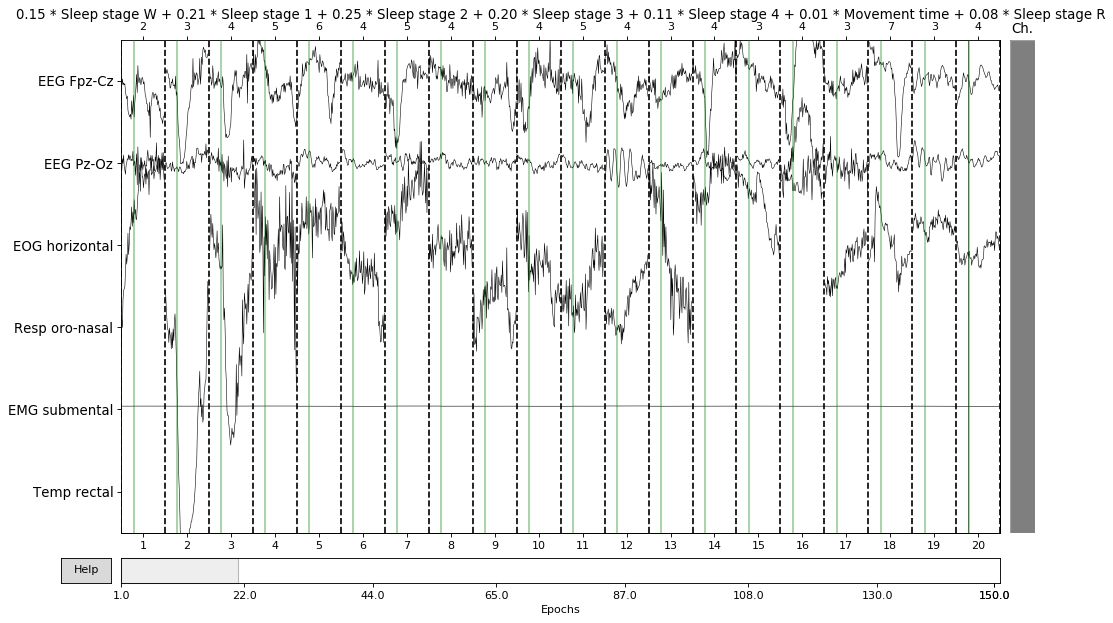

In [58]:
epochs_2.plot()
plt.show()

In [59]:
index, scaling_time, scalings = ['epoch', 'time'], 1e3, dict(grad=1e13)

df_2 = epochs.to_data_frame(picks=None, scalings=scalings,
                          scaling_time=scaling_time, index=index)

Loading data for 151 events and 3001 original time points ...
Converting time column to int64...


In [60]:
df_2

signal           condition  EEG Fpz-Cz  EEG Pz-Oz  EOG horizontal  \
epoch time                                                          
0     0      Sleep stage W  -48.939194   0.067399       34.984127   
      10     Sleep stage W   -8.715751  -3.270330       39.324786   
      20     Sleep stage W  -32.544322  -1.208791       52.346764   
      30     Sleep stage W  -24.499634  -1.208791       52.829060   
      40     Sleep stage W  -35.395604   2.521612       48.488400   
      50     Sleep stage W  -27.860073   2.521612       31.125763   
      60     Sleep stage W  -27.147253   2.128938       26.785104   
      70     Sleep stage W  -16.047619   2.128938       21.479853   
      80     Sleep stage W  -32.136996   1.049084       23.409035   
      90     Sleep stage W  -30.100366  -0.816117       11.351648   
      100    Sleep stage W  -20.833700  -1.601465       46.559219   
      110    Sleep stage W  -20.426374  -7.295238       38.360195   
      120    Sleep stage W  -16.964103 -11.221978       16.656899   
      130    Sleep stage W  -13.603663  -8.375092       33.054945   
      140    Sleep stage W  -12.585348  -3.859341       28.231990   
      150    Sleep stage W   -6.984615  -6.117216       31.125763   
      160    Sleep stage W    3.096703  -4.055678       31.125763   
      170    Sleep stage W    6.966300  -2.975824       24.373626   
      180    Sleep stage W    0.041758  -0.521612        5.081807   
      190    Sleep stage W    3.300366  -1.797802       33.537241   
      200    Sleep stage W    2.791209  -3.270330       -0.705739   
      210    Sleep stage W  -10.854212  -2.681319        2.670330   
      220    Sleep stage W  -10.854212  -1.208791       26.785104   
      230    Sleep stage W   -7.493773  -1.012454        1.223443   
      240    Sleep stage W  -12.279853  -6.313553        6.528694   
      250    Sleep stage W  -15.843956  -6.019048       -6.010989   
      260    Sleep stage W   -2.605861  -6.411722       -2.152625   
      270    Sleep stage W  -17.065934  -0.619780      -17.103785   
      280    Sleep stage W   -3.624176   3.012454        4.117216   
      290    Sleep stage W   -9.530403   4.288645        2.188034   
...                    ...         ...        ...             ...   
150   29710  Sleep stage W   -2.809524  -7.491575       12.798535   
      29720  Sleep stage W    8.391941 -12.400000       28.714286   
      29730  Sleep stage W   13.890842 -11.909158       21.479853   
      29740  Sleep stage W   18.982418 -12.301832       20.515263   
      29750  Sleep stage W   17.353114  -6.215385       22.926740   
      29760  Sleep stage W    2.994872  -4.350183       39.807082   
      29770  Sleep stage W    3.809524  -3.859341       37.395604   
      29780  Sleep stage W    1.467399  -5.528205       44.630037   
      29790  Sleep stage W   13.076190 -13.970696       29.196581   
      29800  Sleep stage W   15.927473 -17.799267       30.643468   
      29810  Sleep stage W   17.047619 -12.596337       48.970696   
      29820  Sleep stage W   19.084249 -12.400000       49.452991   
      29830  Sleep stage W   18.065934 -11.221978       45.594628   
      29840  Sleep stage W   16.232967  -7.884249       29.196581   
      29850  Sleep stage W   16.334799  -3.172161       39.807082   
      29860  Sleep stage W   15.316484   1.736264       18.103785   
      29870  Sleep stage W   14.603663   8.117216       21.479853   
      29880  Sleep stage W    7.577289  11.945788       21.962149   
      29890  Sleep stage W    2.893040  10.080586       20.032967   
      29900  Sleep stage W    6.864469   5.073993       25.338217   
      29910  Sleep stage W   14.400000   2.717949       28.231990   
      29920  Sleep stage W   -5.864469  -5.331868       17.139194   
      29930  Sleep stage W   -4.947985  -9.160440       30.643468   
      29940  Sleep stage W   10.123077  -2.386813       12.798535   
      29950  Sleep stage W   12.567033  -9.062271       26.302808  

In [61]:
df_2 = df_2.reset_index()

In [62]:
df_2

signal,epoch,time,condition,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,Resp oro-nasal,EMG submental,Temp rectal,STI 014
0,0,0,Sleep stage W,-48.939194,0.067399,34.984127,-6.270000e+08,4.024,3.750611e+07,977.0
1,0,10,Sleep stage W,-8.715751,-3.270330,39.324786,-6.210000e+08,4.020,3.750517e+07,977.0
2,0,20,Sleep stage W,-32.544322,-1.208791,52.346764,-6.150000e+08,4.018,3.750517e+07,977.0
3,0,30,Sleep stage W,-24.499634,-1.208791,52.829060,-6.090000e+08,4.016,3.750517e+07,977.0
4,0,40,Sleep stage W,-35.395604,2.521612,48.488400,-6.030000e+08,4.014,3.750517e+07,977.0
5,0,50,Sleep stage W,-27.860073,2.521612,31.125763,-5.960000e+08,4.012,3.750517e+07,977.0
6,0,60,Sleep stage W,-27.147253,2.128938,26.785104,-5.890000e+08,4.010,3.750423e+07,977.0
7,0,70,Sleep stage W,-16.047619,2.128938,21.479853,-5.810000e+08,4.008,3.750423e+07,977.0
8,0,80,Sleep stage W,-32.136996,1.049084,23.409035,-5.730000e+08,4.006,3.750423e+07,977.0
9,0,90,Sleep stage W,-30.100366,-0.816117,11.351648,-5.650000e+08,4.006,3.750423e+07,977.0


In [63]:
cols = ['epoch', 'time', 'condition', 'EEG Fpz-Cz', 'EEG Pz-Oz']
df2 = df_2[cols]

In [64]:
df2

signal,epoch,time,condition,EEG Fpz-Cz,EEG Pz-Oz
0,0,0,Sleep stage W,-48.939194,0.067399
1,0,10,Sleep stage W,-8.715751,-3.270330
2,0,20,Sleep stage W,-32.544322,-1.208791
3,0,30,Sleep stage W,-24.499634,-1.208791
4,0,40,Sleep stage W,-35.395604,2.521612
5,0,50,Sleep stage W,-27.860073,2.521612
6,0,60,Sleep stage W,-27.147253,2.128938
7,0,70,Sleep stage W,-16.047619,2.128938
8,0,80,Sleep stage W,-32.136996,1.049084
9,0,90,Sleep stage W,-30.100366,-0.816117


In [65]:
# Obtain part of dataframe ONLY for Stage 2 Sleep
stage2_df2 = df2[df2['condition'] == 'Sleep stage 2']

In [66]:
stage2_df2

signal,epoch,time,condition,EEG Fpz-Cz,EEG Pz-Oz
6002,2,0,Sleep stage 2,4.522344,-7.589744
6003,2,10,Sleep stage 2,8.391941,-10.731136
6004,2,20,Sleep stage 2,4.522344,-9.651282
6005,2,30,Sleep stage 2,-2.198535,-9.356777
6006,2,40,Sleep stage 2,3.707692,-7.884249
6007,2,50,Sleep stage 2,7.780952,-8.571429
6008,2,60,Sleep stage 2,9.308425,-9.651282
6009,2,70,Sleep stage 2,-1.485714,-7.884249
6010,2,80,Sleep stage 2,2.383883,-6.019048
6011,2,90,Sleep stage 2,-3.115018,-5.037363


In [67]:
# Obtain all the epochs from the Sleep stage 2 extracted dataframe
stage2_df2['epoch'].unique()

array([  2,  13,  15,  17,  19,  21,  23,  41,  43,  47,  51,  53,  55,
        62,  64,  68,  73,  75,  79,  82,  86,  93,  95,  97, 101, 103,
       105, 116, 120, 122, 125, 131, 138, 141, 144, 147, 149])

In [68]:
# Create time vector for a particular epoch:
epoch_bool = stage2_df2['epoch'] == 101
tmp = stage2_df2[epoch_bool]

# Extract the time vector for the epoch choice
time = tmp['time'] / 1e3

# Extract the particular EEG recording we want. In this case, we pick the 'EEG Fpz-Cz' recording
sig = tmp['EEG Fpz-Cz']

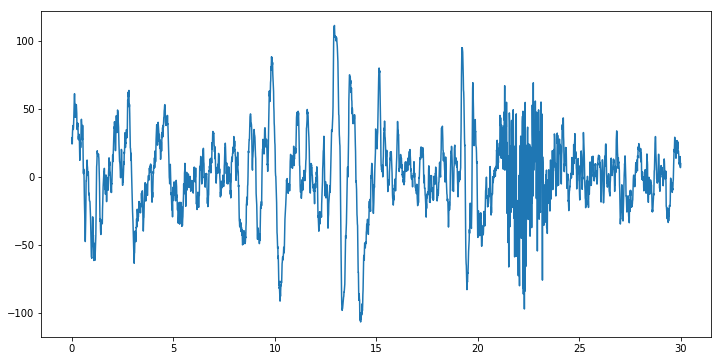

In [69]:
# Plotting the epoch signal against the respective time vector
fig = plt.figure(figsize=(12,6))
plt.plot(time, sig)
plt.show()